# 07: M1/S2 - Unsupervised Anomaly Detection (Sentence Level)

**Cíl:** Detekovat subjektivitu (L1) jako anomálii vůči neutralitě (L0) na úrovni celých vět.
**Metoda:** Mahalanobisova vzdálenost (Unsupervised).
**Hypotéza:** Subjektivní věty se sémanticky liší od neutrálních, takže budou mít v embedding prostoru velkou vzdálenost od centroidu neutrality.

**Scénáře:**
* **S2a - Baseline:** Trénink pouze na Target L0 větách (Gold).
* **S2c - Robustness (Context):** Trénink na Target L0 + Context L0 větách.

**Pooling:**
* Porovnáme **Mean** vs **[CLS]**.

## 1. Setup & Imports

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import logging
from pathlib import Path
import os
from itables import show

from sklearn.metrics import classification_report
from sklearn.decomposition import PCA


# Auto-reload modules for development
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Add src to path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..', 'src'))
if src_dir not in sys.path:
    sys.path.append(src_dir)

# Vlastní moduly
import config
import data_splitting
import models
import evaluation
import visualization


# Logging setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Vizualizace
visualization.setup_style()

print(f"✅ Setup complete. Results dir: {config.RESULTS_DIR}")

⚙️ Configuration loaded. Device: cpu


2026-02-22 22:16:39,128 - INFO - 🎨 Visualization style set: whitegrid


✅ Setup complete. Results dir: C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results


## 2. Data Check
V Unsupervised learningu nás zajímá hlavně počet **Neutrálních (L0)** vět v tréninku. Model se učí jen z nich.

In [2]:
SCENARIOS_TO_CHECK = ['baseline', 'robustness']

print(f"{'='*80}")
print(f"📊 DATA CHECK REPORT (M1/S2 - Unsupervised)")
print(f"{'='*80}")

for sc in SCENARIOS_TO_CHECK:
    print(f"\n🔹 SCÉNÁŘ: {sc.upper()}")
    try:
        # Načteme data (Mean pooling)
        data = data_splitting.get_train_val_test_splits(
            scenario=sc,
            level='sentence',
            pooling='mean',
            random_state=42
        )
        
        # Pro M1 nás v TRAIN zajímá jen L0 (zbytek se zahodí)
        n_train_total = len(data['y_train'])
        n_train_L0 = sum(data['y_train'] == 0)
        n_train_L1 = sum(data['y_train'] == 1)
        
        print(f"   TRAIN (Total): {n_train_total}")
        print(f"   👉 Použitelné pro M1 (L0): {n_train_L0} (Model se učí jen toto)")
        print(f"   👉 Ignorované v Train (L1): {n_train_L1}")
        
        # TADY JSME PŘIDALI VÝPIS PRO VAL
        print(f"   VAL   (Total): {len(data['y_val'])} (L0: {sum(data['y_val']==0)}, L1: {sum(data['y_val']==1)})")
        
        print(f"   TEST  (Total): {len(data['y_test'])} (L0: {sum(data['y_test']==0)}, L1: {sum(data['y_test']==1)})")
        
    except Exception as e:
        print(f"   ❌ Chyba: {e}")

2026-02-22 22:16:39,466 - INFO - 📊 Preparing scenario: baseline (sentence level, aggressive filter)


📊 DATA CHECK REPORT (M1/S2 - Unsupervised)

🔹 SCÉNÁŘ: BASELINE


2026-02-22 22:16:39,689 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl
2026-02-22 22:16:40,151 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-22 22:16:40,161 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-22 22:16:40,173 - INFO - ✅ Document-level split completed:
2026-02-22 22:16:40,176 - INFO -    Train: 376 docs, 376 samples
2026-02-22 22:16:40,178 - INFO -    Val:   41 docs, 41 samples
2026-02-22 22:16:40,181 - INFO -    Test:  103 docs, 103 samples
2026-02-22 22:16:40,186 - INFO -    ✓ No document leakage detected between splits
2026-02-22 22:16:40,189 - INFO - ✅ Scenario data prepared:
2026-02-22 22:16:40,194 - INFO -    Train: 376 samples (L0: 136, L1: 240)
2026-02-22 22:16:40,198 - INFO -    Val:   41 samples (L0: 15, L1: 26)
2026-02-22 22:16:40,203 - INFO -    Test: 

   TRAIN (Total): 376
   👉 Použitelné pro M1 (L0): 136 (Model se učí jen toto)
   👉 Ignorované v Train (L1): 240
   VAL   (Total): 41 (L0: 15, L1: 26)
   TEST  (Total): 103 (L0: 37, L1: 66)

🔹 SCÉNÁŘ: ROBUSTNESS


2026-02-22 22:16:40,821 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-22 22:16:40,829 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-22 22:16:40,842 - INFO - ✅ Document-level split completed:
2026-02-22 22:16:40,847 - INFO -    Train: 376 docs, 1128 samples
2026-02-22 22:16:40,851 - INFO -    Val:   41 docs, 123 samples
2026-02-22 22:16:40,854 - INFO -    Test:  103 docs, 309 samples
2026-02-22 22:16:40,858 - INFO -    ✓ No document leakage detected between splits
2026-02-22 22:16:40,860 - INFO - ✅ Scenario data prepared:
2026-02-22 22:16:40,862 - INFO -    Train: 1128 samples (L0: 888, L1: 240)
2026-02-22 22:16:40,865 - INFO -    Val:   123 samples (L0: 97, L1: 26)
2026-02-22 22:16:40,869 - INFO -    Test:  309 samples (L0: 243, L1: 66)


   TRAIN (Total): 1128
   👉 Použitelné pro M1 (L0): 888 (Model se učí jen toto)
   👉 Ignorované v Train (L1): 240
   VAL   (Total): 123 (L0: 97, L1: 26)
   TEST  (Total): 309 (L0: 243, L1: 66)


## 3. Experiment Loop
Trénujeme **Mahalanobis** detektor.
Iterujeme přes:
1.  **Pooling:** `mean` vs `cls`
2.  **Scénáře:** `baseline` (málo dat) vs `robustness` (hodně L0 dat z kontextu)

In [3]:
RESULTS_PATH = config.RESULTS_DIR / "M1_S2_experiment_results.csv"

# 1. Definice Grid Search
PARAM_GRID = {
    'Mahalanobis': [
        {'method': 'empirical'}, # Klasická vzdálenost
    ],
    'IsolationForest': [
        {'n_estimators': 100, 'max_samples': 'auto', 'contamination': 'auto'}, 
        {'n_estimators': 200, 'max_samples': 'auto', 'contamination': 'auto'},
        {'n_estimators': 100, 'max_samples': 0.8,    'contamination': 'auto'},
    ],
    'OCSVM': [
        {'nu': 0.01, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.10, 'kernel': 'rbf', 'gamma': 'scale'},
        {'nu': 0.05, 'kernel': 'rbf', 'gamma': 0.1},
    ]
}

SCENARIOS = [
    {'id': 'S2a', 'name': 'Baseline (Target L0)',    'scenario': 'baseline'},
    {'id': 'S2c', 'name': 'Robustness (Target+Ctx)', 'scenario': 'robustness'}
]

POOLING_METHODS = ['mean', 'cls']

In [4]:
results = []
best_f1 = 0.0
best_run = None

print(f"🚀 STARTING M1/S2 EXPERIMENTS (Explicit PCA)...")
print(f"💾 Results path: {RESULTS_PATH}")

for pooling in POOLING_METHODS:
    print(f"\n{'#'*60}")
    print(f"🌊 POOLING METHOD: {pooling.upper()}")
    print(f"{'#'*60}")
    
    for exp in SCENARIOS:
        print(f"\n   🧪 SCENARIO: {exp['id']} - {exp['name']}")
        
        try:
            # 1. Načtení dat
            data = data_splitting.get_train_val_test_splits(
                scenario=exp['scenario'],
                level='sentence',
                pooling=pooling,
                random_state=42
            )
            
            # Původní data
            X_train_full = data['X_train']
            y_train_full = data['y_train']
            X_train_L0 = X_train_full[y_train_full == 0] # Pouze L0
            
            X_val, y_val   = data['X_val'], data['y_val']
            X_test, y_test = data['X_test'], data['y_test']
            
            n_samples_train = X_train_L0.shape[0]
            print(f"      📊 Train L0 Size: {n_samples_train} samples")
            
            # 2. Loop přes Modely
            for model_name, params_list in PARAM_GRID.items():
                
                best_val_score = -1
                best_model_instance = None
                best_params = None
                best_thresh = 0
                best_pca = None # Uložíme si i PCA model
                
                # --- PŘÍPRAVA DAT (PCA pro Mahalanobis) ---
                use_pca = (model_name == 'Mahalanobis')
                
                if use_pca:
                    # Bezpečný počet komponent: polovina vzorků, max 50
                    n_components = min(int(n_samples_train / 2), 50)
                    pca = PCA(n_components=n_components, random_state=42)
                    
                    # Transformace dat
                    X_train_curr = pca.fit_transform(X_train_L0)
                    X_val_curr   = pca.transform(X_val)
                    X_test_curr  = pca.transform(X_test)
                    # print(f"        👉 PCA applied: {X_train_L0.shape[1]} -> {n_components} dims")
                else:
                    # Ostatní modely jedou na plných datech
                    X_train_curr = X_train_L0
                    X_val_curr   = X_val
                    X_test_curr  = X_test
                    pca = None

                # --- GRID SEARCH ---
                for params in params_list:
                    try:
                        # Init & Fit (Už posíláme X_train_curr, což je buď raw nebo PCA)
                        # Parametry pro model čistíme od pca_components, kdyby tam byly
                        clean_params = {k:v for k,v in params.items() if k != 'pca_components'}
                        
                        clf = models.get_unsupervised_model(model_name, random_state=42, **clean_params)
                        clf.fit(X_train_curr)
                        
                        # Validate
                        s_val = clf.decision_function(X_val_curr)
                        thresh, val_f1 = evaluation.find_optimal_threshold(y_val, s_val, metric='f1')
                        
                        if val_f1 > best_val_score:
                            best_val_score = val_f1
                            best_model_instance = clf
                            best_params = clean_params
                            best_thresh = thresh
                            best_pca = pca # Uložíme PCA, které k tomu patřilo
                            
                    except Exception as e:
                        # print(f"        ⚠️ Config failed: {e}")
                        continue
                
                # 3. Final Test (s nejlepším nastavením)
                if best_model_instance:
                    s_test = best_model_instance.decision_function(X_test_curr)
                    m_test = evaluation.calculate_metrics(y_test, (s_test > best_thresh).astype(int), s_test)
                    
                    res = {
                        'id': exp['id'],
                        'scenario': exp['scenario'],
                        'scenario_name': exp['name'],
                        'pooling': pooling,
                        'model': model_name,
                        'params': str(best_params),
                        'test_f1': m_test['f1'],
                        'test_auprc': m_test['avg_precision'],
                        'test_roc_auc': m_test['roc_auc']
                    }
                    results.append(res)
                    pd.DataFrame(results).to_csv(RESULTS_PATH, index=False)
                    print(f"      ✅ {model_name:<15} -> Test F1: {m_test['f1']:.4f} (AUPRC: {m_test['avg_precision']:.4f})")
                    
                    # Global Best Check
                    if m_test['f1'] > best_f1:
                        best_f1 = m_test['f1']
                        best_run = {
                            'info': res,
                            'model': best_model_instance,
                            'pca': best_pca, # Důležité pro vizualizaci!
                            'data': data,
                            'scores_test': s_test,
                            'y_test': y_test,
                            'threshold': best_thresh
                        }
                else:
                    print(f"      ❌ {model_name} failed all configs.")

        except Exception as e:
            print(f"   ❌ Error loading data: {e}")

print("\n✅ All experiments finished.")

2026-02-22 22:16:41,402 - INFO - 📊 Preparing scenario: baseline (sentence level, aggressive filter)
2026-02-22 22:16:41,522 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl


🚀 STARTING M1/S2 EXPERIMENTS (Explicit PCA)...
💾 Results path: C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M1_S2_experiment_results.csv

############################################################
🌊 POOLING METHOD: MEAN
############################################################

   🧪 SCENARIO: S2a - Baseline (Target L0)


2026-02-22 22:16:41,928 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-22 22:16:41,938 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-22 22:16:41,953 - INFO - ✅ Document-level split completed:
2026-02-22 22:16:41,955 - INFO -    Train: 376 docs, 376 samples
2026-02-22 22:16:41,957 - INFO -    Val:   41 docs, 41 samples
2026-02-22 22:16:41,961 - INFO -    Test:  103 docs, 103 samples
2026-02-22 22:16:41,968 - INFO -    ✓ No document leakage detected between splits
2026-02-22 22:16:41,971 - INFO - ✅ Scenario data prepared:
2026-02-22 22:16:41,974 - INFO -    Train: 376 samples (L0: 136, L1: 240)
2026-02-22 22:16:41,977 - INFO -    Val:   41 samples (L0: 15, L1: 26)
2026-02-22 22:16:41,979 - INFO -    Test:  103 samples (L0: 37, L1: 66)


      📊 Train L0 Size: 136 samples
      ✅ Mahalanobis     -> Test F1: 0.7170 (AUPRC: 0.5798)


2026-02-22 22:16:43,676 - INFO - 📊 Preparing scenario: robustness (sentence level, aggressive filter)
2026-02-22 22:16:43,790 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl


      ✅ IsolationForest -> Test F1: 0.7355 (AUPRC: 0.6180)
      ✅ OCSVM           -> Test F1: 0.6167 (AUPRC: 0.7108)

   🧪 SCENARIO: S2c - Robustness (Target+Ctx)


2026-02-22 22:16:44,221 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-22 22:16:44,227 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-22 22:16:44,239 - INFO - ✅ Document-level split completed:
2026-02-22 22:16:44,241 - INFO -    Train: 376 docs, 1128 samples
2026-02-22 22:16:44,243 - INFO -    Val:   41 docs, 123 samples
2026-02-22 22:16:44,246 - INFO -    Test:  103 docs, 309 samples
2026-02-22 22:16:44,249 - INFO -    ✓ No document leakage detected between splits
2026-02-22 22:16:44,251 - INFO - ✅ Scenario data prepared:
2026-02-22 22:16:44,254 - INFO -    Train: 1128 samples (L0: 888, L1: 240)
2026-02-22 22:16:44,258 - INFO -    Val:   123 samples (L0: 97, L1: 26)
2026-02-22 22:16:44,260 - INFO -    Test:  309 samples (L0: 243, L1: 66)


      📊 Train L0 Size: 888 samples
      ✅ Mahalanobis     -> Test F1: 0.1916 (AUPRC: 0.1725)
      ✅ IsolationForest -> Test F1: 0.2484 (AUPRC: 0.2110)


2026-02-22 22:16:46,465 - INFO - 📊 Preparing scenario: baseline (sentence level, aggressive filter)
2026-02-22 22:16:46,577 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl


      ✅ OCSVM           -> Test F1: 0.2017 (AUPRC: 0.2708)

############################################################
🌊 POOLING METHOD: CLS
############################################################

   🧪 SCENARIO: S2a - Baseline (Target L0)


2026-02-22 22:16:47,022 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-22 22:16:47,030 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-22 22:16:47,045 - INFO - ✅ Document-level split completed:
2026-02-22 22:16:47,047 - INFO -    Train: 376 docs, 376 samples
2026-02-22 22:16:47,052 - INFO -    Val:   41 docs, 41 samples
2026-02-22 22:16:47,054 - INFO -    Test:  103 docs, 103 samples
2026-02-22 22:16:47,058 - INFO -    ✓ No document leakage detected between splits
2026-02-22 22:16:47,061 - INFO - ✅ Scenario data prepared:
2026-02-22 22:16:47,065 - INFO -    Train: 376 samples (L0: 136, L1: 240)
2026-02-22 22:16:47,070 - INFO -    Val:   41 samples (L0: 15, L1: 26)
2026-02-22 22:16:47,073 - INFO -    Test:  103 samples (L0: 37, L1: 66)


      📊 Train L0 Size: 136 samples
      ✅ Mahalanobis     -> Test F1: 0.7590 (AUPRC: 0.6840)


2026-02-22 22:16:48,652 - INFO - 📊 Preparing scenario: robustness (sentence level, aggressive filter)
2026-02-22 22:16:48,775 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl


      ✅ IsolationForest -> Test F1: 0.7848 (AUPRC: 0.6761)
      ✅ OCSVM           -> Test F1: 0.7654 (AUPRC: 0.6239)

   🧪 SCENARIO: S2c - Robustness (Target+Ctx)


2026-02-22 22:16:49,835 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-22 22:16:49,844 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-22 22:16:49,856 - INFO - ✅ Document-level split completed:
2026-02-22 22:16:49,858 - INFO -    Train: 376 docs, 1128 samples
2026-02-22 22:16:49,860 - INFO -    Val:   41 docs, 123 samples
2026-02-22 22:16:49,862 - INFO -    Test:  103 docs, 309 samples
2026-02-22 22:16:49,864 - INFO -    ✓ No document leakage detected between splits
2026-02-22 22:16:49,869 - INFO - ✅ Scenario data prepared:
2026-02-22 22:16:49,873 - INFO -    Train: 1128 samples (L0: 888, L1: 240)
2026-02-22 22:16:49,876 - INFO -    Val:   123 samples (L0: 97, L1: 26)
2026-02-22 22:16:49,880 - INFO -    Test:  309 samples (L0: 243, L1: 66)


      📊 Train L0 Size: 888 samples
      ✅ Mahalanobis     -> Test F1: 0.3469 (AUPRC: 0.2076)
      ✅ IsolationForest -> Test F1: 0.3444 (AUPRC: 0.2127)
      ✅ OCSVM           -> Test F1: 0.3495 (AUPRC: 0.1930)

✅ All experiments finished.


## 4. Results Overview

📊 SROVNÁNÍ F1 SCORE (Pooling x Model x Scenario):



📊 GRAFICKÉ SROVNÁNÍ MODELŮ:


2026-02-22 22:16:54,444 - INFO - 💾 Saved comparison plot to C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M1_S2_Model_Comparison_F1.png


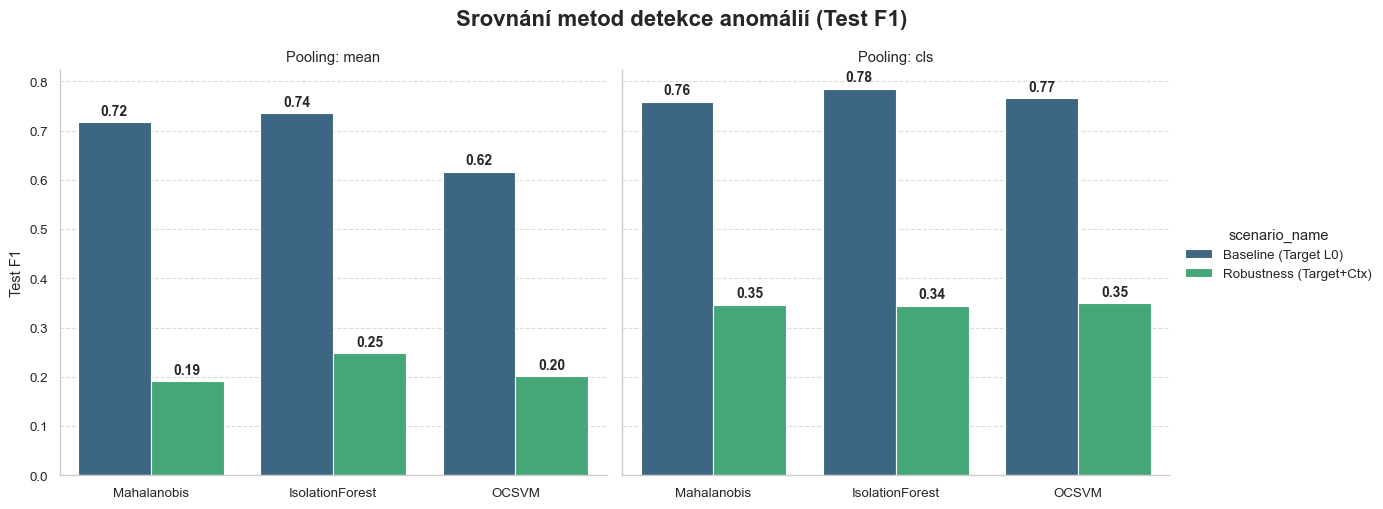

2026-02-22 22:16:56,528 - INFO - 💾 Saved comparison plot to C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M1_S2_Model_Comparison_AUPRC.png


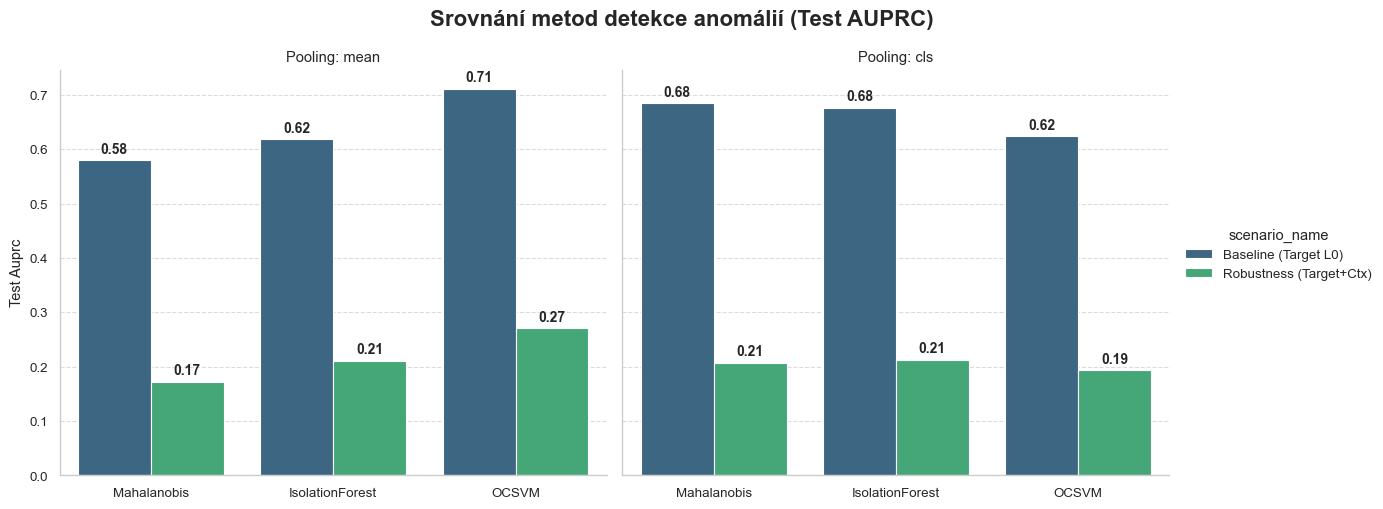

Loading ITables v2.6.2 from the internet... (need help?)


In [5]:
# =============================================================================
# 4. RESULTS OVERVIEW
# =============================================================================

# (Volitelné) Pokud jsi upravil modul za běhu a nechceš restartovat kernel:
import importlib
importlib.reload(visualization)

if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    
    # -------------------------------------------------------------------------
    # A) PIVOT TABLE (Tabulka čísel)
    # -------------------------------------------------------------------------
    print("📊 SROVNÁNÍ F1 SCORE (Pooling x Model x Scenario):")
    
    pivot = df_results.pivot_table(
        values='test_f1', 
        index=['model'], 
        columns=['pooling', 'scenario_name'],
        aggfunc='max'
    )
    
    # Bezpečné řazení (obchází chybu s MultiIndexem)
    mean_scores = pivot.mean(axis=1)
    sorted_idx = mean_scores.sort_values(ascending=False).index
    pivot = pivot.reindex(sorted_idx)
    
    display(pivot.style.background_gradient(cmap='Blues', axis=None).format("{:.4f}"))
    
    # -------------------------------------------------------------------------
    # B) VIZUALIZACE (Nová funkce)
    # -------------------------------------------------------------------------
    print("\n📊 GRAFICKÉ SROVNÁNÍ MODELŮ:")
    
    # 1. F1 Score
    visualization.plot_model_comparison(
        df_results, 
        metric='test_f1',
        title="Srovnání metod detekce anomálií (Test F1)",
        save_path=config.RESULTS_DIR / "M1_S2_Model_Comparison_F1.png"
    )

    # 2. AUPRC (Volitelné, pokud chceš i druhý graf)
    visualization.plot_model_comparison(
        df_results, 
        metric='test_auprc',
        title="Srovnání metod detekce anomálií (Test AUPRC)",
        save_path=config.RESULTS_DIR / "M1_S2_Model_Comparison_AUPRC.png"
    )

    show(df_results)

else:
    print("⚠️ Žádné výsledky. Spusť nejprve trénovací smyčku.")

## 5. Deep Dive: Winner Analysis


2026-02-22 22:16:57,203 - INFO - 📊 Preparing scenario: baseline (sentence level, aggressive filter)
2026-02-22 22:16:57,342 - INFO - ✅ Loaded 1560 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\gold_sentences.pkl


🏆 WINNER (by AUPRC): OCSVM (Baseline (Target L0))
🌊 Pooling: MEAN
📊 AUPRC (Test): 0.7108
📊 F1 (Test):    0.6167
🔄 Reloading data...


2026-02-22 22:16:57,761 - INFO - ✅ Loaded 5709 rows from C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\data\processed\silver_sentences.pkl
2026-02-22 22:16:57,769 - INFO - Splitting 520 documents: 104 test, 41 val, 375 train
2026-02-22 22:16:57,783 - INFO - ✅ Document-level split completed:
2026-02-22 22:16:57,786 - INFO -    Train: 376 docs, 376 samples
2026-02-22 22:16:57,789 - INFO -    Val:   41 docs, 41 samples
2026-02-22 22:16:57,792 - INFO -    Test:  103 docs, 103 samples
2026-02-22 22:16:57,795 - INFO -    ✓ No document leakage detected between splits
2026-02-22 22:16:57,797 - INFO - ✅ Scenario data prepared:
2026-02-22 22:16:57,800 - INFO -    Train: 376 samples (L0: 136, L1: 240)
2026-02-22 22:16:57,803 - INFO -    Val:   41 samples (L0: 15, L1: 26)
2026-02-22 22:16:57,806 - INFO -    Test:  103 samples (L0: 37, L1: 66)


⚙️ Retraining OCSVM with {'nu': 0.05, 'kernel': 'rbf', 'gamma': 0.1}...
🎯 Optimal Threshold (from Val - tuned for F1): -0.1633

📈 Vizualizace ladění prahu (Validační sada):


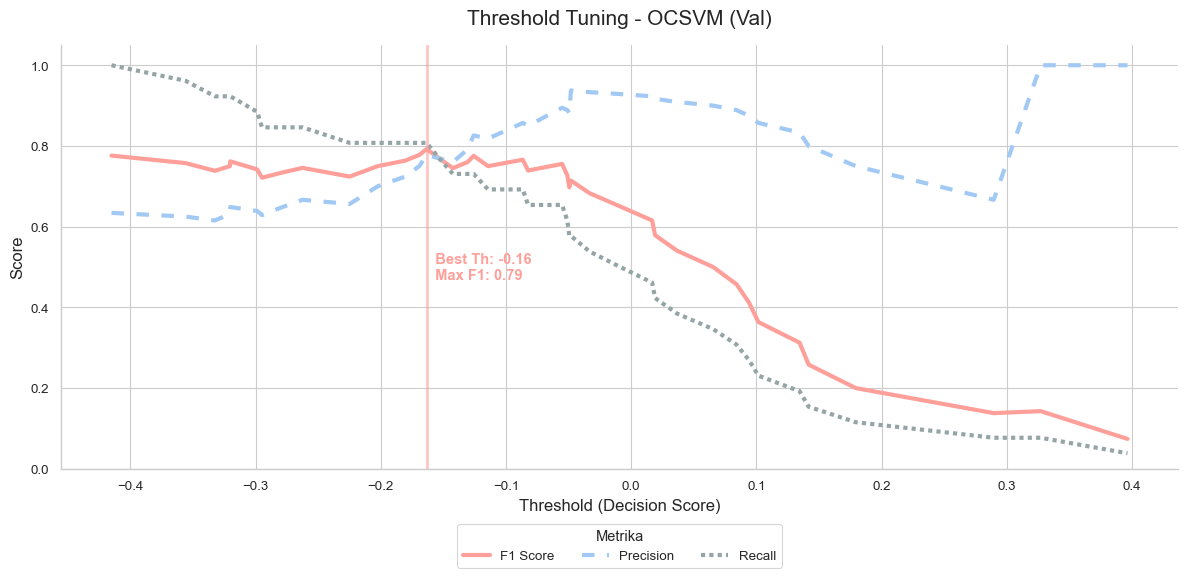


🔹 VAL SET Results (41 samples):
   AUPRC:     0.8338
   F1 Score:  0.7692
   ROC AUC:   0.7359
----------------------------------------
              precision    recall  f1-score   support

Neutral (L0)     0.6000    0.6000    0.6000        15
   Bias (L1)     0.7692    0.7692    0.7692        26

    accuracy                         0.7073        41
   macro avg     0.6846    0.6846    0.6846        41
weighted avg     0.7073    0.7073    0.7073        41


🔹 TEST SET Results (103 samples):
   AUPRC:     0.7108
   F1 Score:  0.6167
   ROC AUC:   0.5446
----------------------------------------
              precision    recall  f1-score   support

Neutral (L0)     0.4082    0.5405    0.4651        37
   Bias (L1)     0.6852    0.5606    0.6167        66

    accuracy                         0.5534       103
   macro avg     0.5467    0.5506    0.5409       103
weighted avg     0.5857    0.5534    0.5622       103



In [6]:
# =============================================================================
# 5. DEEP DIVE: WINNER ANALYSIS (Selection by AUPRC)
# =============================================================================
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import ast

if RESULTS_PATH.exists():
    df_results = pd.read_csv(RESULTS_PATH)
    
    # Vybíráme podle AUPRC
    best_row = df_results.sort_values('test_auprc', ascending=False).iloc[0]
    
    print(f"🏆 WINNER (by AUPRC): {best_row['model']} ({best_row['scenario_name']})")
    print(f"🌊 Pooling: {best_row['pooling'].upper()}")
    print(f"📊 AUPRC (Test): {best_row['test_auprc']:.4f}")
    print(f"📊 F1 (Test):    {best_row['test_f1']:.4f}")
    
    # 1. Reload Data
    print(f"🔄 Reloading data...")
    data_best = data_splitting.get_train_val_test_splits(
        scenario=best_row['scenario'],
        level='sentence',
        pooling=best_row['pooling'],
        random_state=42
    )
    
    X_train_full = data_best['X_train']
    y_train_full = data_best['y_train']
    X_train_L0 = X_train_full[y_train_full == 0] 
    
    X_val,   y_val   = data_best['X_val'],   data_best['y_val']
    X_test,  y_test  = data_best['X_test'],  data_best['y_test']
    
    # 2. PCA Check
    best_model_name = best_row['model']
    
    if best_model_name == 'Mahalanobis':
        n_samples = X_train_L0.shape[0]
        n_components = min(int(n_samples / 2), 50)
        print(f"⚙️ Applying PCA for Mahalanobis ({n_components} dims)...")
        
        pca = PCA(n_components=n_components, random_state=42)
        X_train_curr = pca.fit_transform(X_train_L0)
        X_val_curr   = pca.transform(X_val)
        X_test_curr  = pca.transform(X_test)
    else:
        X_train_curr = X_train_L0
        X_val_curr   = X_val
        X_test_curr  = X_test

    # 3. Retrain Model
    try:
        params_dict = ast.literal_eval(best_row['params'])
    except:
        print("⚠️ Warning: Could not parse params, using defaults.")
        params_dict = {}

    print(f"⚙️ Retraining {best_model_name} with {params_dict}...")
    clean_params = {k:v for k,v in params_dict.items() if k != 'pca_components'}
    
    clf = models.get_unsupervised_model(best_model_name, random_state=42, **clean_params)
    clf.fit(X_train_curr)
    
    # 4. Scores & Threshold Tuning
    s_val  = clf.decision_function(X_val_curr)
    s_test = clf.decision_function(X_test_curr)
    
    # A) Najdeme optimální práh (číslo) - Tady parametr 'metric' zůstává (find_optimal_threshold ho umí)
    thresh, _ = evaluation.find_optimal_threshold(y_val, s_val, metric='f1')
    print(f"🎯 Optimal Threshold (from Val - tuned for F1): {thresh:.4f}")

    # B) Vykreslíme graf ladění
    print("\n📈 Vizualizace ladění prahu (Validační sada):")
    
    # ✅ OPRAVA: Odstraněn parametr metric='f1' (funkce ho neumí a automaticky kreslí F1)
    visualization.plot_threshold_tuning(
        y_val, 
        s_val, 
        title=f"Threshold Tuning - {best_model_name} (Val)"
    )

    # 5. Aplikace prahu a Report
    p_val  = (s_val > thresh).astype(int)
    p_test = (s_test > thresh).astype(int)
    
    def print_metrics(name, y_true, y_pred, scores):
        m = evaluation.calculate_metrics(y_true, y_pred, scores)
        print(f"\n🔹 {name} SET Results ({len(y_true)} samples):")
        print(f"   AUPRC:     {m['avg_precision']:.4f}")
        print(f"   F1 Score:  {m['f1']:.4f}")
        print(f"   ROC AUC:   {m['roc_auc']:.4f}")
        print("-" * 40)
        print(classification_report(y_true, y_pred, target_names=['Neutral (L0)', 'Bias (L1)'], digits=4))

    print_metrics("VAL",   y_val,   p_val,   s_val)
    print_metrics("TEST",  y_test,  p_test,  s_test)

else:
    print("⚠️ Nemám výsledky. Spusť nejprve trénovací smyčku.")

#### VIZUALIZACE


📊 VIZUALIZACE VÝKONU:


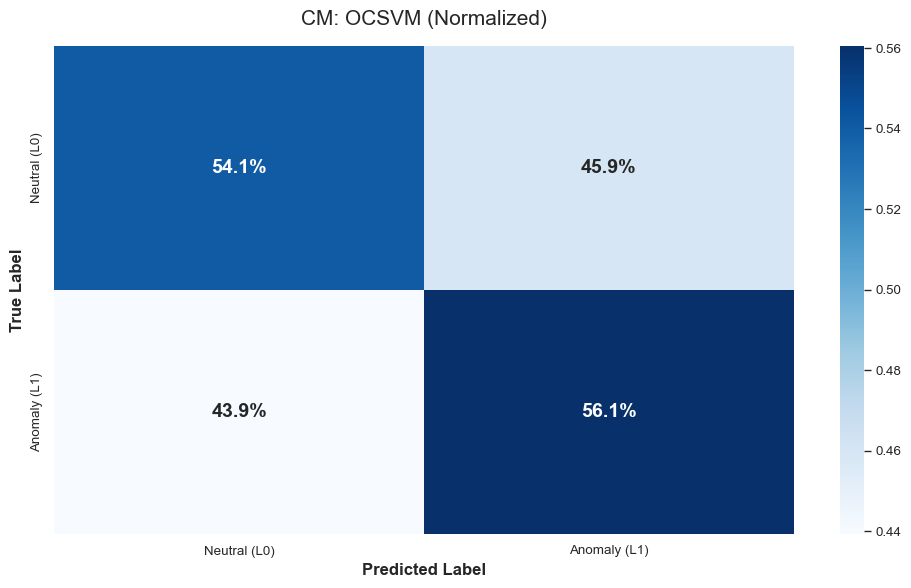

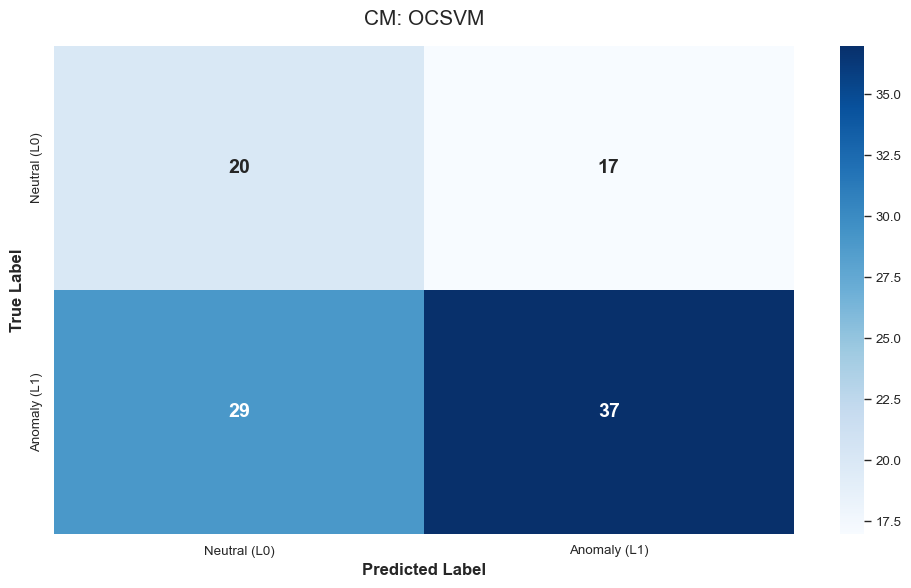

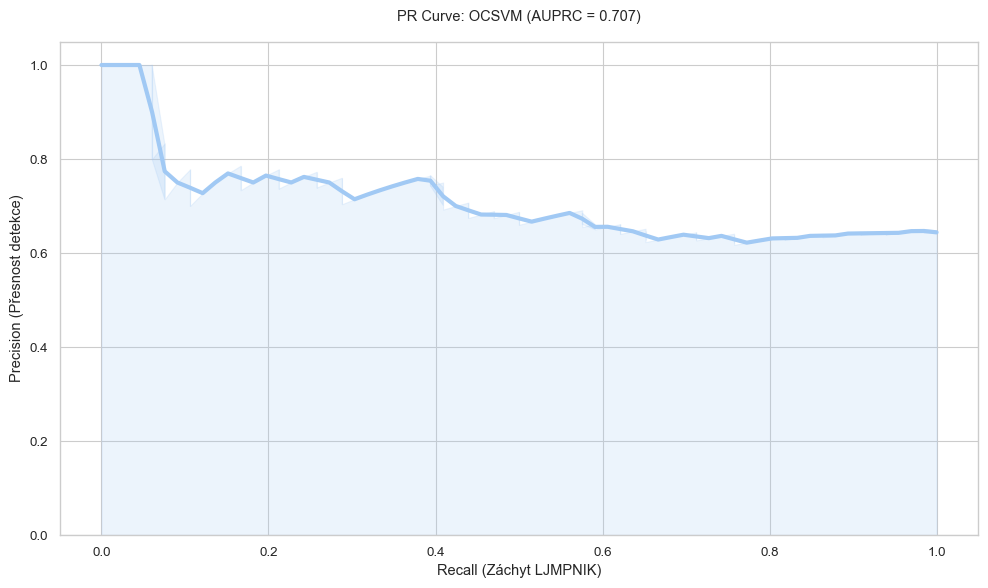

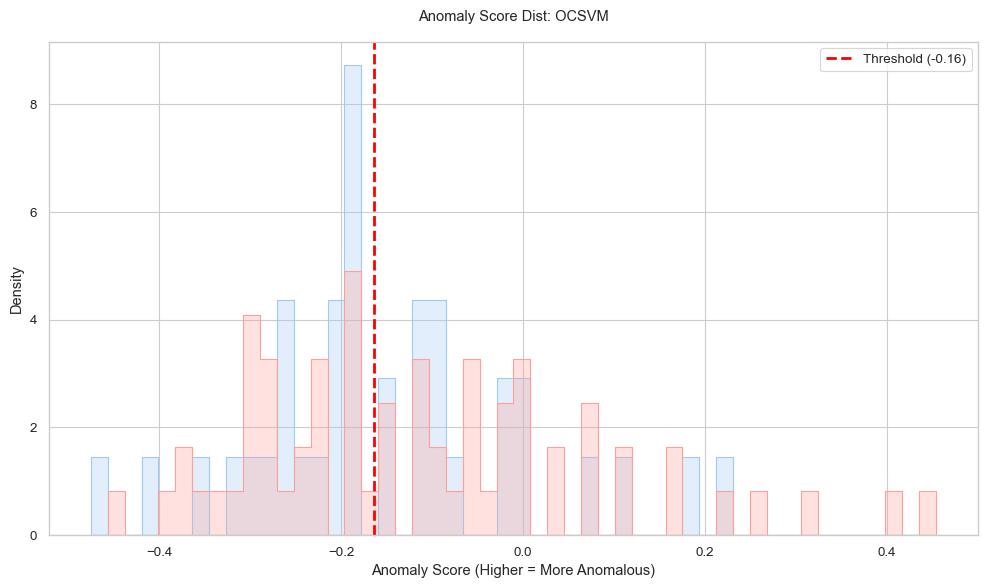

In [7]:
# =============================================================================
# 6. VIZUALIZACE (Standardní grafy)
# =============================================================================

print("\n📊 VIZUALIZACE VÝKONU:")

# Confusion Matrix
visualization.plot_confusion_matrix_heatmap(
    y_test, 
    p_test, 
    normalize=True, 
    title=f"CM: {best_model_name}"
)

visualization.plot_confusion_matrix_heatmap(
    y_test, 
    p_test, 
    normalize=False, 
    title=f"CM: {best_model_name}"
)

# Precision-Recall Curve
visualization.plot_pr_curve(
    y_test, 
    s_test, 
    title=f"PR Curve: {best_model_name}"
)

# Anomaly Score Distribution (Histogram)
# Ukazuje, jak moc jsou oddělené L0 a L1 skóre
visualization.plot_anomaly_histogram(
    y_test, 
    s_test, 
    threshold=thresh, 
    title=f"Anomaly Score Dist: {best_model_name}"
)

#### EMBEDDING PROJECTION

🎨 Počítám projekce pro OCSVM...


2026-02-22 22:17:14,718 - INFO - 1️⃣ Computing PCA...
2026-02-22 22:17:14,735 - INFO - 2️⃣ Computing t-SNE...
2026-02-22 22:17:19,508 - INFO - 3️⃣ Computing UMAP...



🔹 Vizualizace: PCA


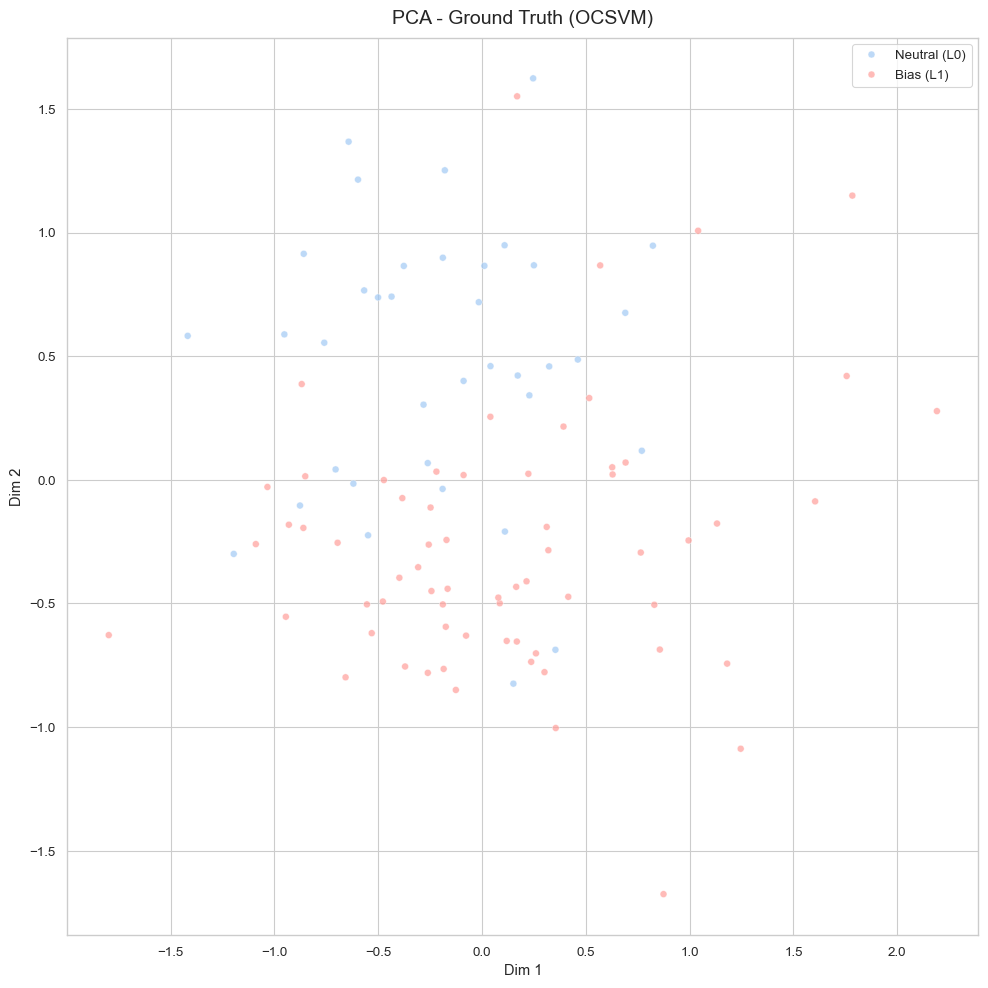

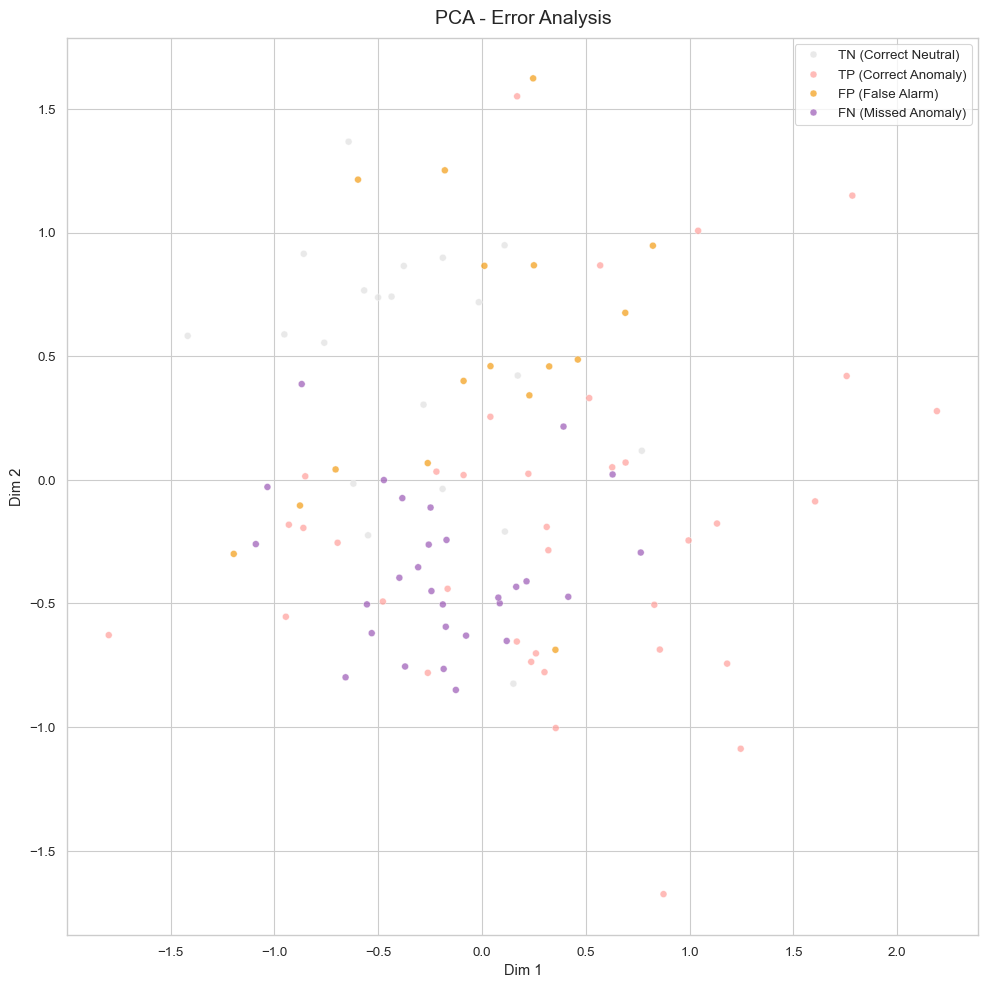


🔹 Vizualizace: t-SNE


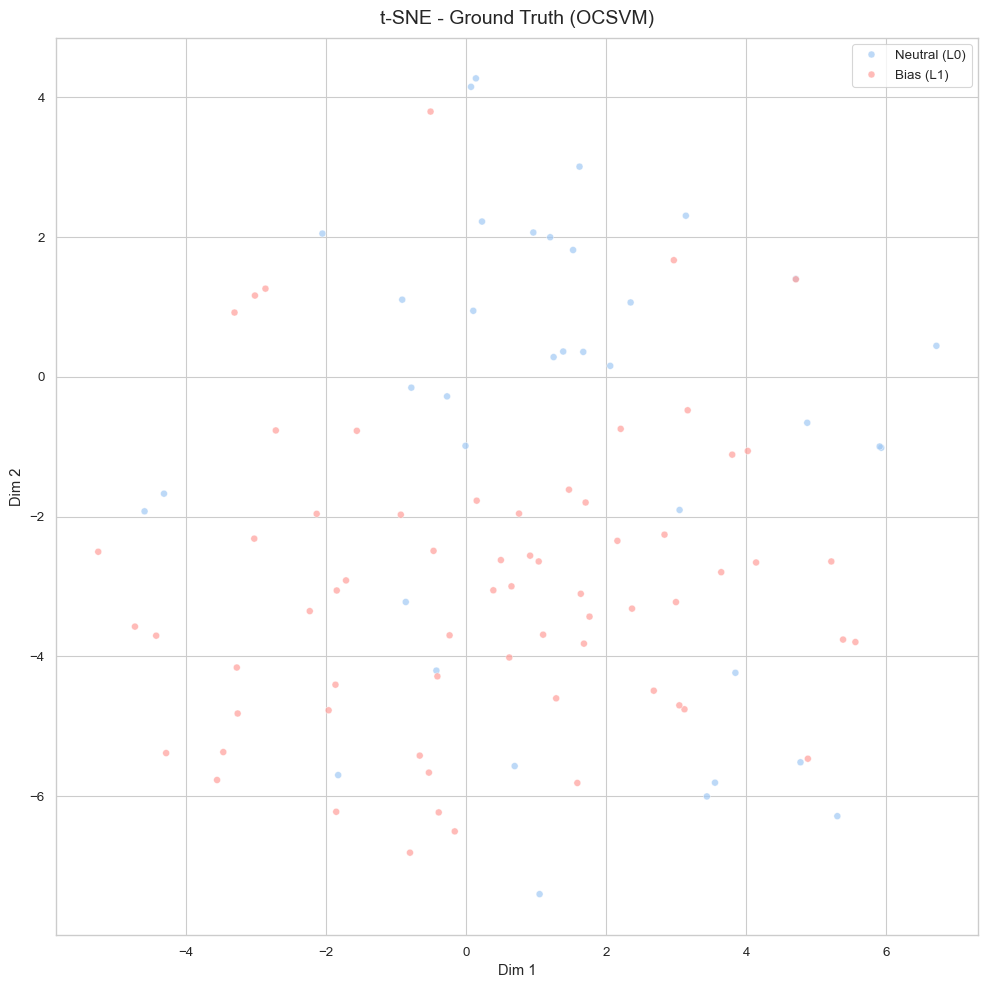

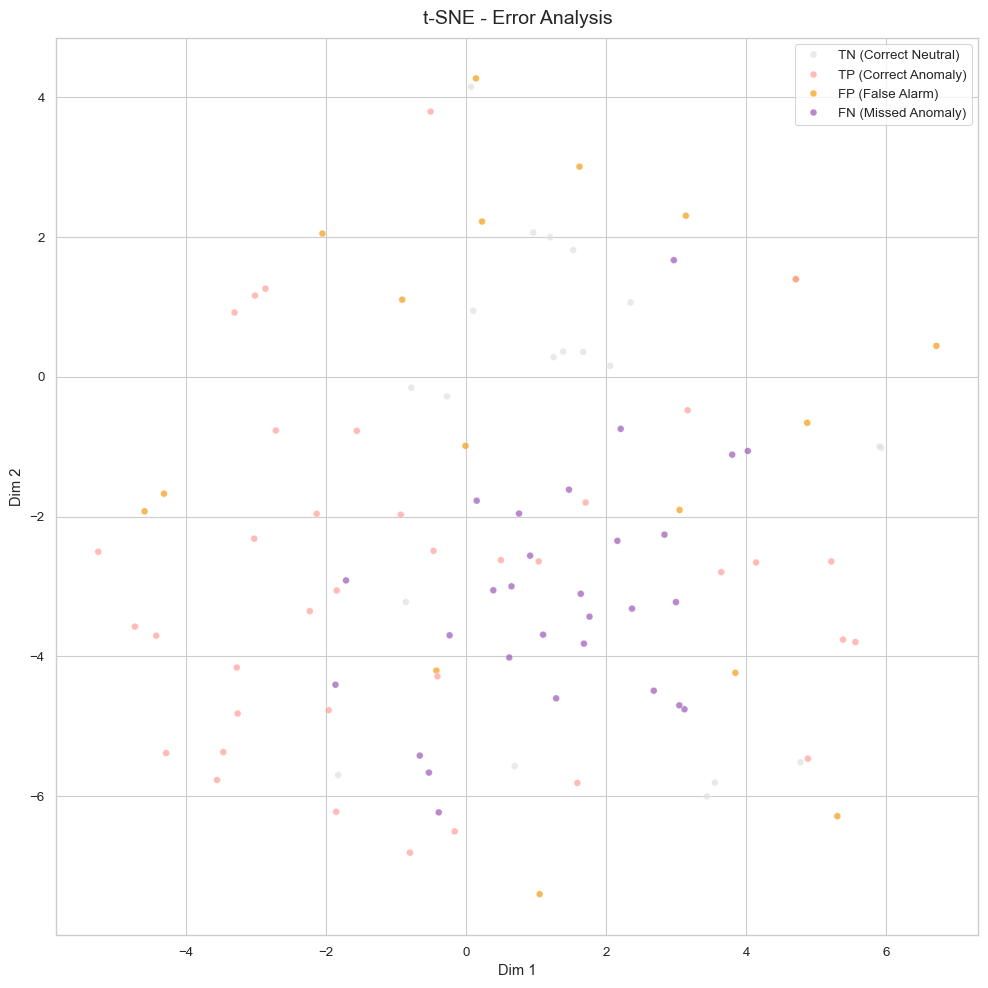


🔹 Vizualizace: UMAP


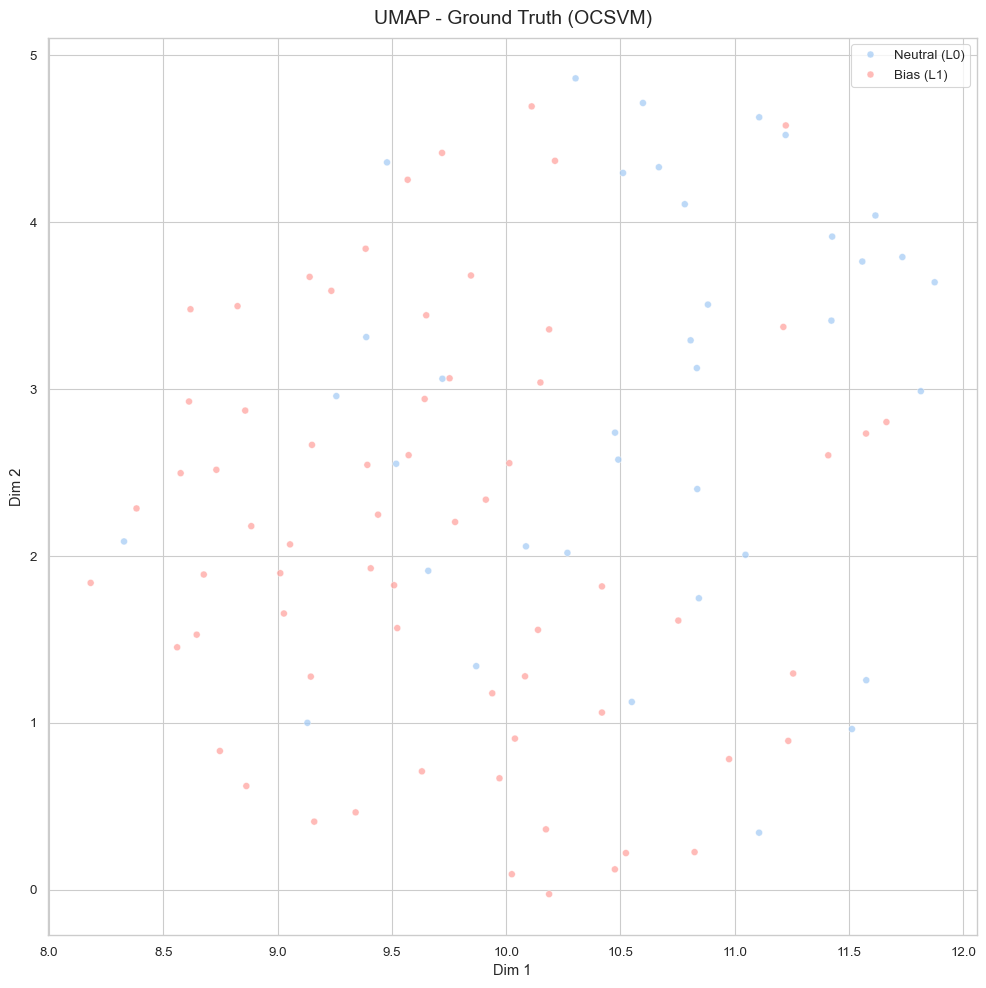

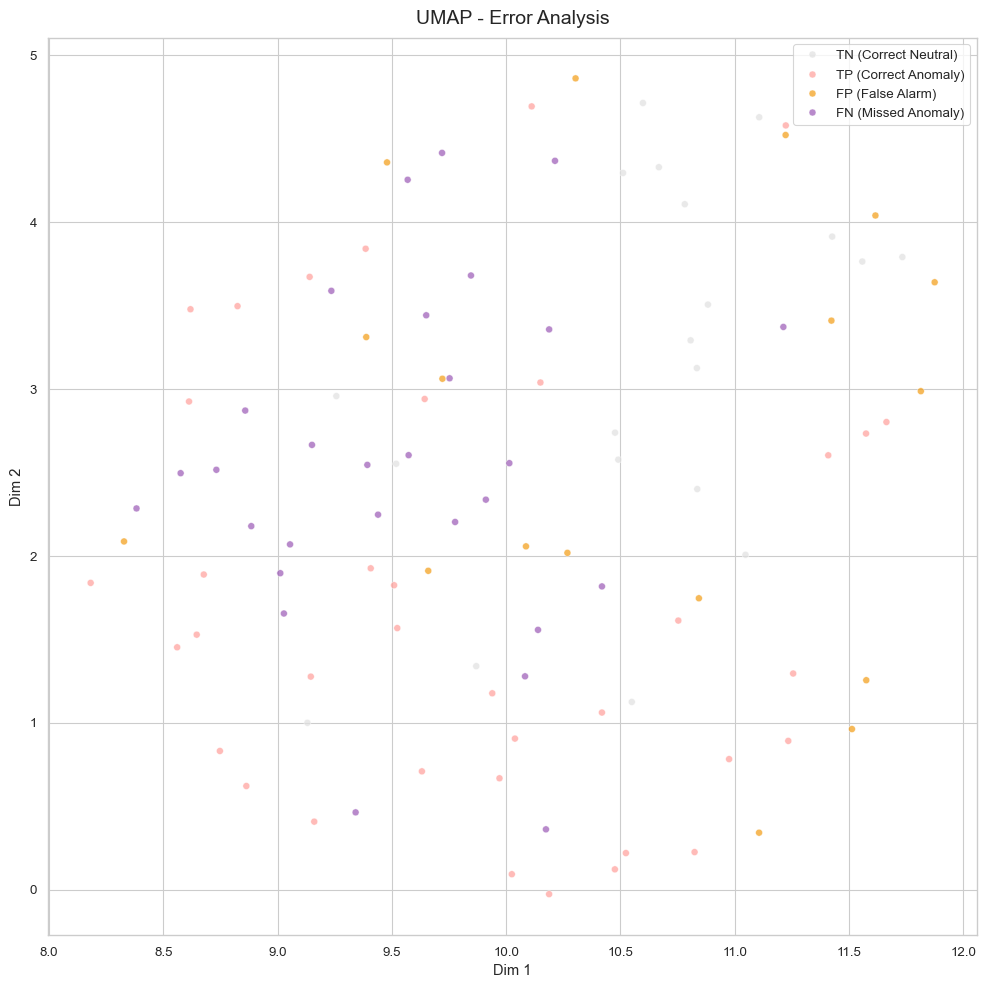


✅ Všechny projekce uloženy.


In [8]:
# =============================================================================
# 7. EMBEDDING PROJECTION (PCA, t-SNE, UMAP)
# =============================================================================

# Použijeme data a výsledky přímo z předchozí buňky (Deep Dive)
# To zaručuje, že vizualizujeme přesně to, co jsme právě vyhodnotili.

print(f"🎨 Počítám projekce pro {best_model_name}...")

# 1. Příprava dat
# X_test: Surová data (768 dim), abychom viděli přirozené rozložení vět
# (Pokud chceš vidět to, co viděl model po PCA, použij 'X_test_curr')
X_input = X_test 
y_test_input = y_test
scores_input = s_test

# Predikce už máme hotové z Deep Dive (p_test), nemusíme je počítat z prahu
y_pred_input = p_test

# 2. Výpočet projekcí (funkce sama udělá subsampling, pokud je dat moc)
projections, indices = visualization.compute_projections(
    X_input, 
    methods=['PCA', 't-SNE', 'UMAP'],
    random_state=42
)

# 3. Filtrace labelů (musíme vybrat stejné vzorky, jako vybral subsampling)
y_test_viz = y_test_input[indices]
y_pred_viz = y_pred_input[indices]

# 4. Generování grafů
for method, coords in projections.items():
    print(f"\n🔹 Vizualizace: {method}")
    
    # --- A) Ground Truth (Co to reálně je) ---
    labels_gt = pd.Series(y_test_viz).map({
        0: 'Neutral (L0)', 
        1: 'Bias (L1)'
    })
    
    visualization.plot_embedding_projection(
        coords=coords, 
        labels=labels_gt,
        palette={
            'Neutral (L0)': config.COLORS['l0'], 
            'Bias (L1)': config.COLORS['l1']
        },
        title=f"{method} - Ground Truth ({best_model_name})",
        hue_order=['Neutral (L0)', 'Bias (L1)'],
        save_path=config.RESULTS_DIR / f"M1_S2_proj_{method}_GT_{best_model_name}.png"
    )
    
    # --- B) Error Analysis (Kde model chyboval - TP/FP/TN/FN) ---
    visualization.plot_error_analysis_projection(
        coords=coords,
        y_true=y_test_viz,
        y_pred=y_pred_viz,
        method_name=method,
        save_path=config.RESULTS_DIR / f"M1_S2_proj_{method}_Errors_{best_model_name}.png"
    )

print("\n✅ Všechny projekce uloženy.")

## QUALITATIVE ANALYSIS

In [9]:
# =============================================================================
# 8. QUALITATIVE ANALYSIS (Detailní pohled na chyby)
# =============================================================================

# 1. Vezmeme existující metadata
df_qual = data_best['meta_test'].copy()

# 2. Přidáme výsledky
df_qual['true_label'] = y_test
df_qual['pred_label'] = p_test
df_qual['anomaly_score'] = s_test

# 3. Určení kategorie (TP, TN, FP, FN)
conds = [
    (df_qual['true_label'] == 1) & (df_qual['pred_label'] == 1), # TP (Bias odhalen)
    (df_qual['true_label'] == 0) & (df_qual['pred_label'] == 0), # TN (Neutral poznán)
    (df_qual['true_label'] == 0) & (df_qual['pred_label'] == 1), # FP (Falešný poplach)
    (df_qual['true_label'] == 1) & (df_qual['pred_label'] == 0)  # FN (Přehlédnutý bias)
]

df_qual['category'] = np.select(conds, ['TP', 'TN', 'FP', 'FN'], default='UNKNOWN')

# 4. Úklid sloupců
preferred_cols = ['document_id', 'sentence_id', 'text', 'true_label', 'pred_label', 'anomaly_score', 'category']
final_cols = [c for c in preferred_cols if c in df_qual.columns]
remaining_cols = [c for c in df_qual.columns if c not in final_cols]
df_qual = df_qual[final_cols + remaining_cols]

# 5. Výpis TOP chyb
print(f"\n❌ TOP 5 FP (Falešný poplach - Model křičí 'Bias!', ale je to Neutral):")
print("   -> Tyto věty jsou modelu 'podezřelé'. Možná jsou opravdu divné?")
display(df_qual[df_qual['category'] == 'FP'].sort_values('anomaly_score', ascending=False).head(5))

print(f"\n❌ TOP 5 FN (Přehlédnutý bias - Model říká 'Neutral', ale je to Bias):")
print("   -> Tyto věty model považuje za normální. Jsou příliš subtilní?")
display(df_qual[df_qual['category'] == 'FN'].sort_values('anomaly_score', ascending=True).head(5))

# 6. Uložení
save_path = config.RESULTS_DIR / "M1_S2_Qualitative_Analysis.csv"
df_qual.to_csv(save_path, index=False)
print(f"\n💾 Detailní analýza uložena: {save_path}")


❌ TOP 5 FP (Falešný poplach - Model křičí 'Bias!', ale je to Neutral):
   -> Tyto věty jsou modelu 'podezřelé'. Možná jsou opravdu divné?


,document_id,sentence_id,text,true_label,pred_label,anomaly_score,category
1260,gold_doc_0421,gold_doc_0421_target,"Výnosy jsou letos průměrné , kvalita je dobrá .",0,1,0.225885,FP
1290,gold_doc_0431,gold_doc_0431_target,Za jízdu na červenou hrozí vyšší pokuta .,0,1,0.181843,FP
687,gold_doc_0230,gold_doc_0230_target,V norimberském procesu byla organizace SS ozna...,0,1,0.118119,FP
1212,gold_doc_0405,gold_doc_0405_target,Obžalovaný byl zproštěn viny v plném rozsahu .,0,1,0.072776,FP
519,gold_doc_0174,gold_doc_0174_target,Při nehodě došlo ke srážce tří osobních vozide...,0,1,0.004912,FP



❌ TOP 5 FN (Přehlédnutý bias - Model říká 'Neutral', ale je to Bias):
   -> Tyto věty model považuje za normální. Jsou příliš subtilní?


,document_id,sentence_id,text,true_label,pred_label,anomaly_score,category
912,gold_doc_0305,gold_doc_0305_target,"Nový výzkum odhalil chování vlka , který je ty...",1,0,-0.445182,FN
30,gold_doc_0011,gold_doc_0011_target,Naprosté selhání dozorových orgánů vedlo k opo...,1,0,-0.388680,FN
132,gold_doc_0045,gold_doc_0045_target,Babiš si zavařil sám a proto zahájil nové jedn...,1,0,-0.378165,FN
1161,gold_doc_0388,gold_doc_0388_target,Od začátku sezóny vstoupí v platnost to nové p...,1,0,-0.366718,FN
723,gold_doc_0242,gold_doc_0242_target,Město při plánování průmyslového parku o rozlo...,1,0,-0.357849,FN



💾 Detailní analýza uložena: C:\Users\dobes\Documents\UniversityCodingProject_10-02-26\ThesisCoding\results\M1_S2_Qualitative_Analysis.csv
